# Plan:

1-Exploration des données

2-Données textuelles

          -CountVectoriszer
          
          -Vectorisation par TD-IDF (Term frequency-inverse document frequency)
          
          - Word2vec

Après chaque extraction des features on applique la méthode de clusterisation K-Means ; sauf dans le cas de TF-IDF. Les résultats obtenus de chaque segmentation sont évalués avec l'ARI (Adjusted Rand Index) Score.

Puis, à l'aide du méthode T-SNE, nous visualisons les segmentations et nous vérifions les résultats avec une Matrice de Confusion.

Nous sélectionnons le meilleure ARI Score parmi toutes les segmentations (données textuelles et graphiques). Enfin nous visualisons la classification avec le meilleur score. 

In [398]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import scipy.stats as stats
import plotly.offline as po
import plotly.graph_objs as gobj
import re
import math
from os import listdir
import csv
import requests
import warnings
import json
import autopep8
import pickle
import logging
import datetime as dt
import time
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
import transformers
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
import importlib
from IPython.display import display
from nltk import bigrams
from nltk import FreqDist
from string import punctuation
from sklearn import manifold, decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from os import listdir
from skimage.transform import resize
warnings.filterwarnings('ignore')

In [399]:
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
print(data.shape)
data.sample(3)

(1050, 15)


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
674,2bf0ca6d25501c067cd12a2a4939443f,2015-12-31 09:19:31 +0000,http://www.flipkart.com/home-fashion-gallery-p...,Home Fashion Gallery Polyester Black Plain Eye...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNECSYF7U72GEQH,2498.0,1499.0,2bf0ca6d25501c067cd12a2a4939443f.jpg,False,Buy Home Fashion Gallery Polyester Black Plain...,No rating available,No rating available,Home Fashion Gallery,"{""product_specification""=>[{""key""=>""Reversible..."
176,154920adb9d584b55d419227f9b01cc6,2015-12-01 12:40:44 +0000,http://www.flipkart.com/printland-pmr1051-cera...,Printland PMR1051 Ceramic Mug,"[""Kitchen & Dining >> Coffee Mugs >> Printland...",MUGEBFGFRUMZGKNN,650.0,299.0,154920adb9d584b55d419227f9b01cc6.jpg,False,Printland PMR1051 Ceramic Mug (350 ml)\r\n ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va..."
936,6e6694c52c9273cde2163d34d5b44e94,2016-01-01 13:15:34 +0000,http://www.flipkart.com/my-party-suppliers-720...,My Party Suppliers 720 inch Multicolor Rice Li...,"[""Home Decor & Festive Needs >> Decorative Lig...",RCLECHFGUXERJRN2,1900.0,850.0,6e6694c52c9273cde2163d34d5b44e94.jpg,False,Buy My Party Suppliers 720 inch Multicolor Ric...,No rating available,No rating available,My Party Suppliers,"{""product_specification""=>[{""key""=>""Brand"", ""v..."


In [400]:
data.shape

(1050, 15)

In [401]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [402]:
# les colonnes des données
data.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [403]:
data.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

In [404]:
# valeurs Manquantes
data.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

<Axes: >

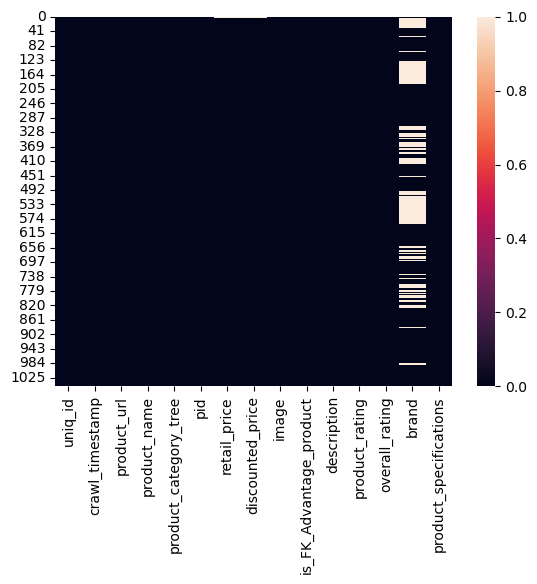

In [405]:
sns.heatmap(data.isna())

In [406]:
!pip install missingno

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


<Axes: >

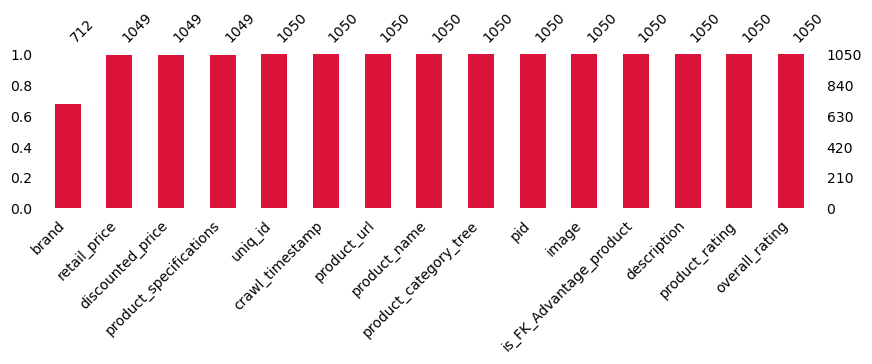

In [407]:
import missingno as msno
msno.bar(data, figsize=(10, 2), fontsize=10, color='crimson', sort='ascending')

Nous allons désormais observer si le dataframe comporte des données dupliquées.

In [408]:
print("Nombre de commandes dupliquées : ", data[data.duplicated()].shape[0])
data[data.duplicated(keep=False)]

Nombre de commandes dupliquées :  0


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications


Nous n'avons donc pas de données dupliquées

**catégories**

Voyons maintenant plus en détail la variable 'product_category_tree' qui est la variable qui nous intéresse dans le cadre de la prédiction de la catégorie d'un article.
Comme on peut le voir, la colonne product_category_tree contient trois niveaux de catégories pour chaque produit. Par conséquent, nous allons diviser ces niveaux en trois colonnes différentes : categ_1, categ_2 et categ_3

In [409]:
data["product_category_tree"].value_counts().sum()

1050

In [410]:
data["product_category_tree"].nunique()

642

In [411]:
data["product_category_tree"]

0       ["Home Furnishing >> Curtains & Accessories >>...
1       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
                              ...                        
1045    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1046    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1047    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1048    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1049    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
Name: product_category_tree, Length: 1050, dtype: object

In [412]:
data["categ_1"] = ""

for i in data.index:
    string = data['product_category_tree'][i]
    characters = "'\"[]"
    string = ''.join( x for x in string if x not in characters)
    string =str.split(string, ">>")
    
    data["categ_1"][i] = data["categ_1"][i].replace("", string[0])

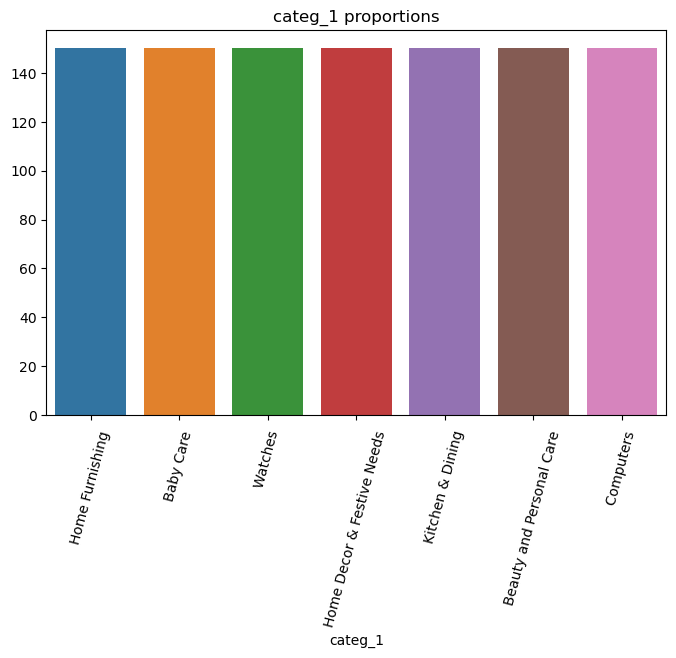

In [413]:
import seaborn as sns
import matplotlib.pyplot as plt

cat_1 = data['categ_1'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=cat_1.index, y=cat_1.values)
plt.title('categ_1 proportions')
plt.xticks(rotation=75)
plt.show()


**Supprimer les colonnes qui ne nous interesse pas**

In [414]:
data = data.drop(columns=[
    'product_category_tree',
    'uniq_id',
    'crawl_timestamp',
    'product_url',
    'pid',
    'brand',
    'retail_price',
    'discounted_price',
    'is_FK_Advantage_product',
    'product_rating',
    'overall_rating',
    'product_specifications',
])

data.head(3)

,product_name,image,description,categ_1
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care


In [415]:
data["product_info"] = data["product_name"].map(str) + " " + data["description"]
data = data.drop(["description"],axis=1)
data.head(3)

,product_name,image,categ_1,product_info
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,Sathiyas Cotton Bath Towel Specifications of S...
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,Eurospa Cotton Terry Face Towel Set Key Featur...


In [416]:
data.to_csv("data_text_clean.csv")

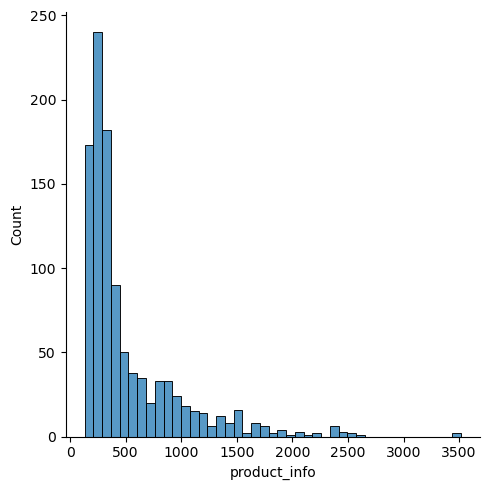

In [417]:
tmp = data.product_info.str.len()
sns.displot(tmp)

<Axes: >

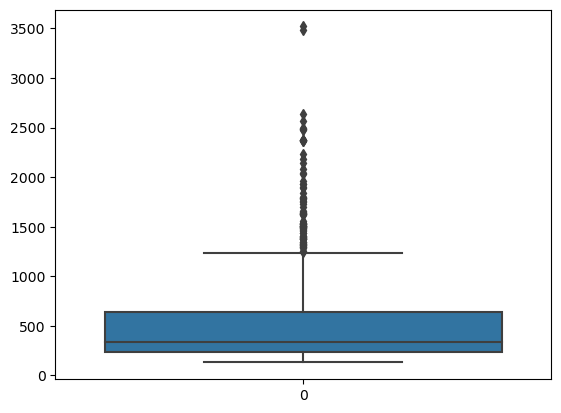

In [418]:
sns.boxplot(tmp)

# Préparation des données

# PARTIE 1 : Données "TEXTE"

**Prétraitement de texte**

Nous allons désormais appliquer différentes transformations sur notre texte :

-suppression des stopwords

-tokénisation : C'est un processus de division d'une chaîne de texte en un ensemble de "tokens" ou unités de sens. Un token peut être un mot, une ponctuation, un nombre, un symbole ou toute autre unité significative dans un texte.

-lemmatisation : représenter les mots (ou « lemmes ») sous leur forme canonique. Par exemple pour un verbe, ce sera son infinitif. Pour un nom, son masculin singulier. L'idée étant de ne conserver que le sens des mots utilisés dans le corpus.

-stemming (ou racinisation): consiste à ne conserver que la racine des mots étudiés. L'idée étant de supprimer les suffixes, préfixes et autres des mots afin de ne conserver que leur origine. C'est un procédé plus simple que la lemmatisation et plus rapide à effectuer puisqu'on tronque les mots essentiellement contrairement à la lemmatisation qui nécessite d'utiliser un dictionnaire.

Nous créons de nouvelles variables dans notre dataframe, comprenant les différentes transformations réalisées sur la variable description.

*-Nous avons la colonne product_info qui a été mise en minuscule, tokenisée et les stopwords ont été retirés dans la variable 'product_info_bow'. 

*-La variable 'product_info_lem' comporte les mêmes étapes mais avec une étape de lemmatisation en plus.

*-De même pour la variable 'product_info_stem' mais avec une étape de stemming. 

Ces variables sont des préparations du texte pour le bag of words.

*-Enfin, 'product_info_dl' est une préparation du texte pour le Deep learning (avec des algorithmes tels que USE et BERT). Elle consiste à tokéniser et mettre en minuscule la description.

Afin d'utiliser ces données pour l'apprentissage automatique, nous devons être en mesure de convertir le contenu de chaque chaîne en un vecteur de nombres.

In [419]:
# nom_description
data[["product_name", "product_info"]].head()

,product_name,product_info
0,Elegance Polyester Multicolor Abstract Eyelet ...,Elegance Polyester Multicolor Abstract Eyelet ...
1,Sathiyas Cotton Bath Towel,Sathiyas Cotton Bath Towel Specifications of S...
2,Eurospa Cotton Terry Face Towel Set,Eurospa Cotton Terry Face Towel Set Key Featur...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,SANTOSH ROYAL FASHION Cotton Printed King size...
4,Jaipur Print Cotton Floral King sized Double B...,Jaipur Print Cotton Floral King sized Double B...


# **Fonctions à utiliser pour traitement de texte**

In [420]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
def tokenizer_fct(sentence):
    ''' Tokenisation du texte en argument.'''
    word_tokens = word_tokenize(sentence)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
def stop_word_filter_fct(list_words, stop_w) :
    ''' Filtrage de la liste de mots avec les stopwords renseignés en argument.'''
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    '''Transformation de la liste de mots en minuscule.'''
    lw = [w.lower() for w in list_words]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    '''Lemmatizer'''
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w


# racinisation
def stem_fct(list_words) :
    '''racinisation'''
    stemmer = PorterStemmer()
    stem_w = [stemmer.stem(w) for w in list_words]
    return stem_w


# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text, stop_w) :
    '''Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)'''
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens, stop_w)
    lw = lower_start_fct(sw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text, stop_w) :
    '''Fonction de préparation du texte pour le bag of words avec lemmatization.'''
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens, stop_w)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

def transform_bow_stem_fct(desc_text, stop_w) :
    '''Fonction de préparation du texte pour le bag of words avec stemming.'''
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens, stop_w)
    lw = lower_start_fct(sw)
    stem_w = stem_fct(lw)    
    transf_desc_text = ' '.join(stem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text, stop_w) :
    '''Fonction de préparation du texte pour le Deep learning (USE et BERT).'''
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

In [421]:
stopwords_nltk = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
stop_words = set.union(stopwords_nltk, stopwords_punct)

In [422]:
from nltk.stem import PorterStemmer
data['name_bow'] = data['product_name'].apply(lambda x : transform_bow_fct(x, stop_words))
data['product_info_bow'] = data['product_info'].apply(lambda x : transform_bow_fct(x, stop_words))
data['length_bow'] = data['product_info_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data['length_bow'].max())

data['name_bow_lem'] = data['product_name'].apply(lambda x : transform_bow_lem_fct(x, stop_words))
data['product_info_bow_lem'] = data['product_info'].apply(lambda x : transform_bow_lem_fct(x, stop_words))
data['length_bow_lem'] = data['product_info_bow_lem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow lem : ", data['length_bow_lem'].max())

data['name_bow_stem'] = data['product_name'].apply(lambda x : transform_bow_stem_fct(x, stop_words))
data['product_info_bow_stem'] = data['product_info'].apply(lambda x : transform_bow_stem_fct(x, stop_words))
data['length_bow_stem'] = data['product_info_bow_stem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow stem : ", data['length_bow_stem'].max())

data['name_dl'] = data['product_name'].apply(lambda x : transform_dl_fct(x, stop_words))
data['product_info_dl'] = data['product_info'].apply(lambda x : transform_dl_fct(x, stop_words))
data['length_dl'] = data['product_info_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data['length_dl'].max())

max length bow :  384
max length bow lem :  384
max length bow stem :  384
max length dl :  645


In [423]:
le = LabelEncoder()
le.fit(data["categ_1"])
data["label"] = le.transform(data["categ_1"])

In [424]:
l_cat = ['Baby Care','Beauty and Personal Care','Computers','Home Decor & Festive Needs',
            'Home Furnishing','Kitchen & Dining','Watches']

In [425]:
data.head(3)

,product_name,image,categ_1,product_info,name_bow,product_info_bow,length_bow,name_bow_lem,product_info_bow_lem,length_bow_lem,name_bow_stem,product_info_bow_stem,length_bow_stem,name_dl,product_info_dl,length_dl,label
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...,163,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...,163,eleg polyest multicolor abstract eyelet door c...,eleg polyest multicolor abstract eyelet door c...,163,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...,255,4
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,Sathiyas Cotton Bath Towel Specifications of S...,sathiyas cotton bath towel,sathiyas cotton bath towel specifications sath...,67,sathiyas cotton bath towel,sathiyas cotton bath towel specification sathi...,67,sathiya cotton bath towel,sathiya cotton bath towel specif sathiya cotto...,67,sathiyas cotton bath towel,sathiyas cotton bath towel specifications of s...,88,0
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,Eurospa Cotton Terry Face Towel Set Key Featur...,eurospa cotton terry face towel set,eurospa cotton terry face towel set key featur...,164,eurospa cotton terry face towel set,eurospa cotton terry face towel set key featur...,164,eurospa cotton terri face towel set,eurospa cotton terri face towel set key featur...,164,eurospa cotton terry face towel set,eurospa cotton terry face towel set key featur...,259,0


# Fonctions communes

In [426]:
def ARI_fct_tsne(features, l_cat, label_true) :
    '''Calcul Tsne, détermination des clusters et calcul ARI entre les vraies catégories et n° de clusters.'''
    time1 = time.time()
    nb_clusters = len(l_cat)
    
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, 
                init='random', learning_rate=200, random_state=0)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = KMeans(n_clusters=nb_clusters, n_init=100, random_state=0)
    cls.fit(X_tsne)
    ARI = np.round(adjusted_rand_score(label_true, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

def TSNE_visu_fct(X_tsne, l_cat, label_true, labels, ARI) :
    '''Visualisation du Tsne selon les vraies catégories et selon les clusters.'''
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=label_true, cmap='Set1')
    legend = ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    for text in legend.get_texts():
        text.set_fontsize(4)  # Ajuster la taille de la police
    plt.title('Représentation par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    legend = ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    for text in legend.get_texts():
        text.set_fontsize(8)  # Ajuster la taille de la police
    plt.title('Représentation par clusters')
    
    plt.show()
    print("ARI : ", ARI)




def plot_TSNE_images(X, data, path):
    '''Affiche le graphe TSNE en 2 dimensions avec les images à la place des points.'''
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(15, 15))
    ax = plt.subplot(111)

    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])
        for i in range(df.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 5e-4:
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            props={'boxstyle':'round', 'edgecolor':'white'}
            
            image = imread(path + df['image'][i])
            image = resize(image, (230, 230)) 

            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(image,zoom=0.1),
                                                X[i], bboxprops=props)
            ax.add_artist(imagebox)

# Bag of words

Le bag of words est une méthode de représentation de texte dans le domaine du traitement de texte. Elle consiste à représenter un document ou une phrase sous la forme d'un ensemble de mots, en ignorant l'ordre dans lequel ils apparaissent et en ne prenant en compte que leur fréquence d'apparition.

# 1-CountVectorizer

CountVectorizer transforme chaque document en un vecteur de nombres entiers qui représentent le nombre d'occurrences de chaque mot dans le document.

Les paramètres max_df et min_df sont utilisés pour contrôler la sélection des mots à inclure dans la matrice de compte de termes générée par CountVectorizer. Ici, cela signifie que les mots présents dans plus de 95% des documents seront ignorés et les mots présents dans moins de 1 document seront ignorés.

In [427]:
feat_1= 'name_bow_lem'
feat_2= 'product_info_bow_lem'  

In [428]:
cv = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
cv_fit = cv.fit(data[feat_1])
cv_transform = cv.transform(data[feat_2])  

Afin de pouvoir visualiser nos données sur une représentation 2D, nous appliquons un TSNE à 2 composantes.

In [429]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

print("CountVectorizer : ")
ARI_cv, X_tsne_cv, labels_cv = ARI_fct_tsne(cv_transform, l_cat, data["label"])

CountVectorizer : 
ARI :  0.4616 time :  11.0


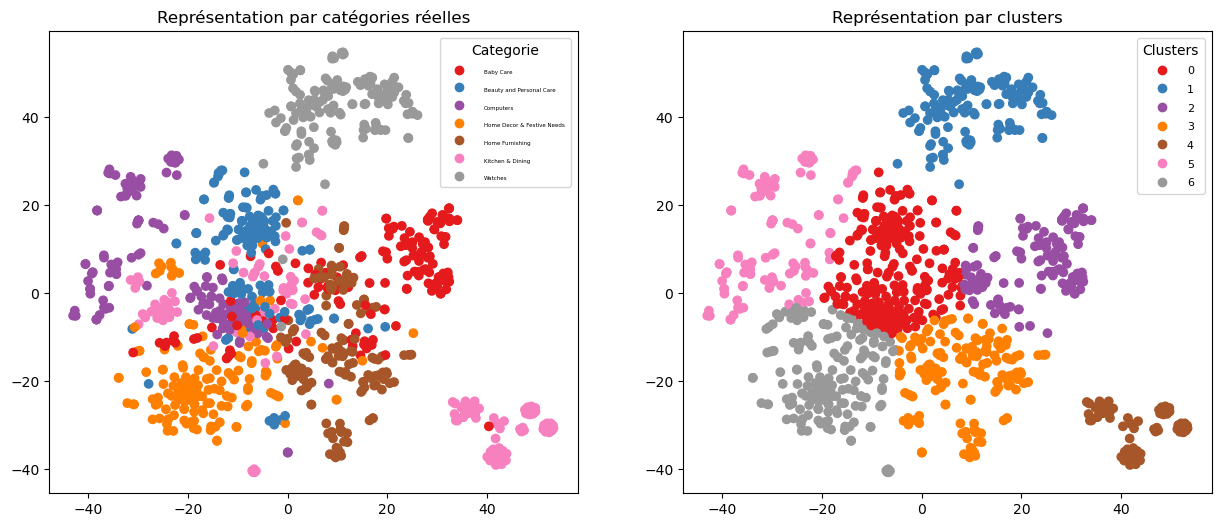

ARI :  0.4616


In [430]:
TSNE_visu_fct(X_tsne_cv, l_cat, data["label"], labels_cv, ARI_cv)

On constate que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réelle. En effet, on constate que certaines catégories se mélangent plus dans la représentation réelle (Home Decor & Festive Needs, Home Furnishing et Kitchen & Dining par exemple). D'autres clusters semblent assez bien déterminés, ce sont les catégories qui semblent les plus espacées dans la représentation réelle comme Watches, Beauty and Personal Care ou encore Baby Care.

L'ARI (Adjusted Rand Index ou Indice Rand Ajusté) est une mesure de la similarité entre deux clustering de données.  Ici nous obtenons un assez bon ARI à 0.4616.

# 2-Tf-idf

Tf-idf (ou term frequency-inverse document frequency) est une technique de traitement de texte couramment utilisée pour évaluer l'importance relative d'un terme dans un document. Elle mesure la fréquence d'apparition d'un terme dans un document et l'inverse de la fréquence d'apparition du terme dans tous les documents d'une collection. En d'autres termes, plus un terme apparaît fréquemment dans un document donné et moins il apparaît dans l'ensemble de la collection, plus son poids Tf-idf est élevé.

In [431]:
tfv = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)
tfv_fit = tfv.fit(data[feat_1])
tfv_transform = tfv.transform(data[feat_2])  

Afin de pouvoir visualiser nos données sur une représentation 2D, nous appliquons un TSNE à 2 composantes.

In [432]:
print("Tf-idf : ")
ARI_tfv, X_tsne_tfv, labels_tfv = ARI_fct_tsne(tfv_transform, l_cat, data["label"])

Tf-idf : 
ARI :  0.4639 time :  12.0


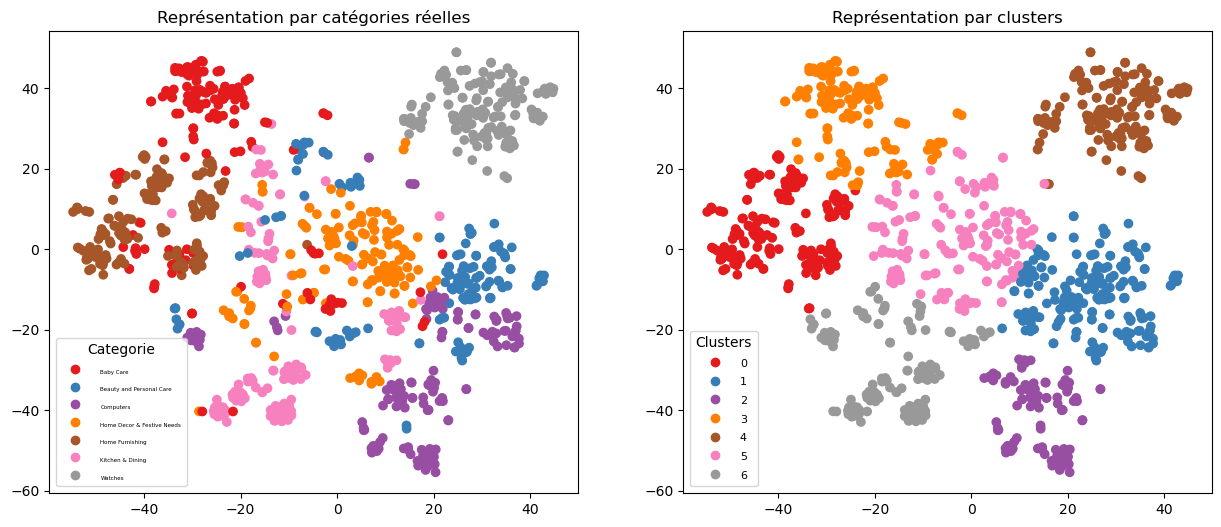

ARI :  0.4639


In [433]:
TSNE_visu_fct(X_tsne_tfv, l_cat, data["label"], labels_tfv, ARI_tfv)

On constate que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réélle. En effet, on constate que la plupart des catégories se mélangent plus dans la représentation réelle. D'autres clusters semblent un peu mieux déterminés, ce sont les catégories qui semblent les plus espacées dans la représentation réelle comme Watches.

Ici nous obtenons un ARI légèrement meilleur que pour le CountVectorizer.

# Word2Vec

In [434]:
import gensim

In [435]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data['product_info_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [436]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4756
Word2Vec trained


In [437]:
!pip install keras

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [438]:
!pip install tensorflow

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [439]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [440]:
# Préparation des sentences (tokenization)
import keras
import tensorflow
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4757


# Création de la matrice d'embedding

In [441]:
from keras.preprocessing.text import Tokenizer

In [442]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4757, 300)


# Création du modèle d'embedding

In [443]:
# Création du modèle
from tensorflow.keras.layers import Input, Embedding
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 24)]              0         
                                                                 
 embedding_7 (Embedding)     (None, 24, 300)           1427100   
                                                                 
 global_average_pooling1d_5  (None, 300)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
Total params: 1427100 (5.44 MB)
Trainable params: 1427100 (5.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Exécution du modèle

In [444]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 2ms/step


(1050, 300)

In [445]:
ARI, X_tsne, labels = ARI_fct_tsne(embeddings, l_cat, data["label"])

ARI :  0.181 time :  10.0


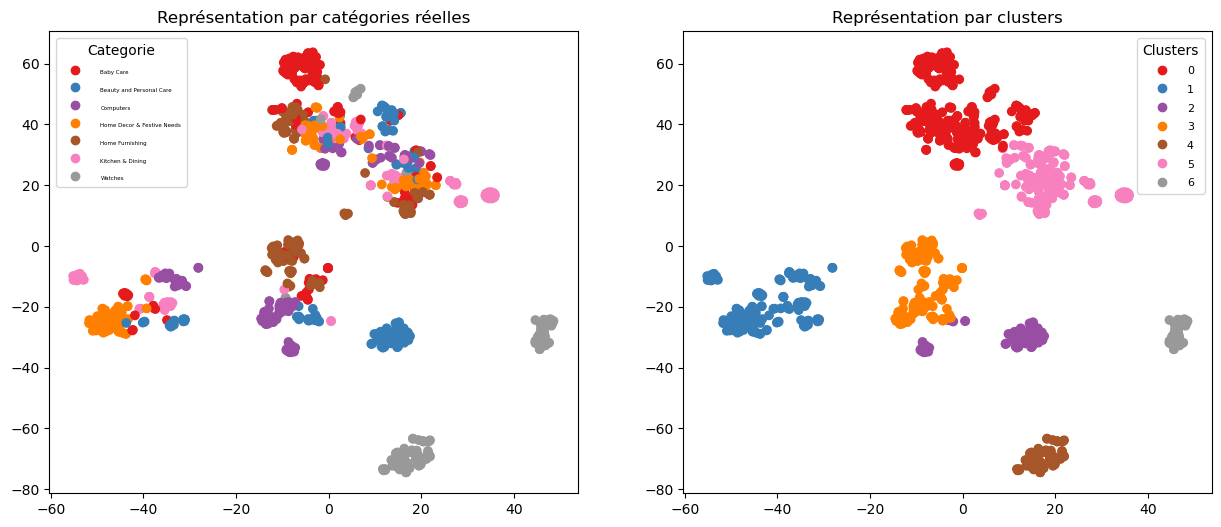

ARI :  0.181


In [446]:
TSNE_visu_fct(X_tsne, l_cat, data["label"], labels, ARI)

# BERT

BERT utilise le word embedding en prenant en compte tout le document et la position des mots, et prédit un mot en fonction de son contexte en utilisant des masks.

In [447]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.15.0
2.15.0
Num GPUs Available:  0
False


**Fonctions communes**

In [448]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [449]:
!pip install tensorflow-hub

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [450]:
!pip install tensorflow-text

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [451]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

#model_url = 'https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/3'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [452]:
sentences = data['product_info_dl'].to_list()

In [453]:
from transformers import AutoTokenizer

max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  162.0


In [454]:
ARI, X_tsne, labels = ARI_fct_tsne(features_bert, l_cat, data["label"])

ARI :  0.4445 time :  11.0


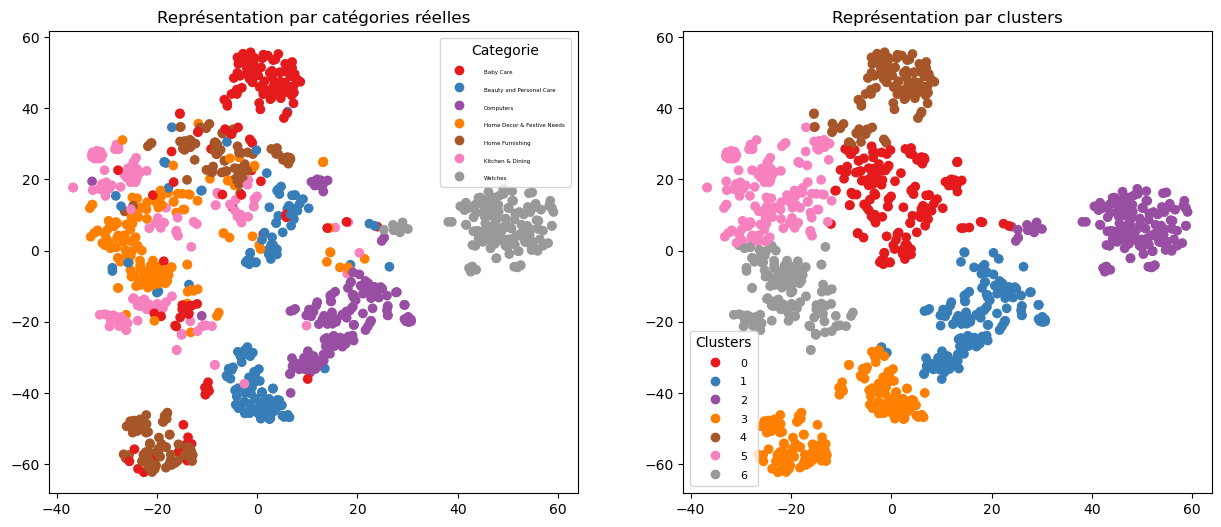

ARI :  0.4445


In [455]:
TSNE_visu_fct(X_tsne, l_cat, data["label"], labels, ARI)

# USE - Universal Sentence Encoder

USE représente des phrases ou des paragraphes selon des vecteurs denses qui permettent de mesurer la similarité sémantique entre les phrases.

In [456]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.15.0
2.15.0
Num GPUs Available:  0
False


In [495]:
import time
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

# Charger le modèle Universal Sentence Encoder
#embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/3")
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/1")

In [496]:
def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        feat_dict = embed(sentences[idx:idx+batch_size])

        # Imprimer les clés du dictionnaire
        print("Keys in the dictionary:", feat_dict.keys())
        print("Dictionary content:", feat_dict)



        # Utiliser une clé appropriée pour extraire les embeddings
        feat_numpy = feat_dict['outputs'].numpy()  # Mettez la clé correcte ici
        
        if step == 0:
            features = feat_numpy
        else:
            features = np.concatenate((features, feat_numpy))

    time2 = np.round(time.time() - time1, 0)
    return features


In [497]:
batch_size = 10
sentences = data['product_info_dl'].to_list()

In [498]:
features_USE = feature_USE_fct(sentences, batch_size)

Keys in the dictionary: dict_keys(['outputs'])
Dictionary content: {'outputs': <tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.05467377, -0.02532437,  0.01860047, ...,  0.05160292,
         0.04837078, -0.01826265],
       [-0.04975678, -0.02272141,  0.01577211, ...,  0.03462832,
         0.03524185,  0.03179984],
       [-0.05735895,  0.01821648, -0.04174837, ...,  0.05707666,
        -0.04948239, -0.04864341],
       ...,
       [-0.05868637, -0.06168121, -0.05100207, ..., -0.00348601,
         0.02183058, -0.0513054 ],
       [-0.04769634, -0.05096386, -0.01872506, ..., -0.01941102,
        -0.05391732, -0.06684815],
       [-0.0084627 , -0.05457464, -0.05974803, ...,  0.01881317,
        -0.05371365, -0.06121305]], dtype=float32)>}
Keys in the dictionary: dict_keys(['outputs'])
Dictionary content: {'outputs': <tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.05796321, -0.05063497, -0.01407936, ...,  0.01695618,
        -0.02773516, -0.03610748],
       [-0

Keys in the dictionary: dict_keys(['outputs'])
Dictionary content: {'outputs': <tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.0635628 , -0.05994969, -0.0503355 , ..., -0.01398067,
        -0.04600884, -0.00079687],
       [-0.04750494, -0.0604417 , -0.04849995, ...,  0.00028584,
        -0.04647622, -0.03376432],
       [-0.00504706, -0.06296085, -0.04410332, ..., -0.02754644,
        -0.02203289, -0.0509603 ],
       ...,
       [-0.04977477, -0.06188102, -0.05805881, ..., -0.03807997,
        -0.01739328, -0.06199956],
       [-0.06340597, -0.06063041, -0.05241995, ..., -0.0092067 ,
        -0.03623825,  0.00524183],
       [-0.050165  , -0.06060974, -0.05073192, ...,  0.01490553,
        -0.04569421, -0.04781966]], dtype=float32)>}
Keys in the dictionary: dict_keys(['outputs'])
Dictionary content: {'outputs': <tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.06366938, -0.0602971 , -0.0583315 , ..., -0.0138244 ,
        -0.042145  , -0.00745952],
       [-0

Keys in the dictionary: dict_keys(['outputs'])
Dictionary content: {'outputs': <tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.04823189, -0.07061911, -0.05584697, ...,  0.01734879,
        -0.0330775 , -0.05386664],
       [-0.02938345, -0.07837984,  0.02205524, ...,  0.02956033,
        -0.02238016, -0.02898794],
       [-0.03915951, -0.08041628, -0.0325914 , ...,  0.02983426,
         0.05785456, -0.01272532],
       ...,
       [-0.03731579, -0.08035457,  0.04255614, ..., -0.02054668,
         0.0434513 , -0.07520492],
       [-0.02353988, -0.07330468, -0.06852399, ...,  0.05327727,
        -0.01191312, -0.03934715],
       [ 0.00305178, -0.06999388, -0.02374599, ...,  0.04676928,
        -0.04703411, -0.03006889]], dtype=float32)>}
Keys in the dictionary: dict_keys(['outputs'])
Dictionary content: {'outputs': <tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.0216737 , -0.06945551, -0.04060451, ...,  0.02523299,
        -0.01710819,  0.00228792],
       [-0

Keys in the dictionary: dict_keys(['outputs'])
Dictionary content: {'outputs': <tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.06035554,  0.03624445, -0.06044813, ..., -0.00475083,
         0.02894568, -0.01630188],
       [-0.06118002, -0.05004377, -0.02142014, ...,  0.06018787,
         0.04201227, -0.02722995],
       [-0.04344593, -0.06737287,  0.02151575, ..., -0.05403449,
        -0.03041138, -0.04437405],
       ...,
       [-0.06489647, -0.06530276,  0.02927076, ...,  0.04671717,
        -0.01701924, -0.0116202 ],
       [-0.04923743, -0.05512273,  0.06207002, ...,  0.04723367,
        -0.0183557 , -0.05853942],
       [-0.0168803 , -0.04760526, -0.05549859, ...,  0.05089379,
         0.04491226, -0.05146153]], dtype=float32)>}
Keys in the dictionary: dict_keys(['outputs'])
Dictionary content: {'outputs': <tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.06190911, -0.05651378, -0.05652533, ...,  0.04552999,
        -0.05443111, -0.0133344 ],
       [-0

Keys in the dictionary: dict_keys(['outputs'])
Dictionary content: {'outputs': <tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.05906904,  0.01352709,  0.02044265, ...,  0.05769878,
         0.06076985, -0.0152126 ],
       [-0.05687917, -0.05625438, -0.05034743, ..., -0.03408286,
        -0.05103097, -0.05676451],
       [-0.04829355, -0.05476755, -0.03772793, ...,  0.037783  ,
        -0.05282979, -0.05726051],
       ...,
       [-0.05683251, -0.04017071,  0.05551187, ..., -0.0235152 ,
        -0.04747465, -0.05988377],
       [-0.05541523, -0.04754457,  0.06112132, ..., -0.03355709,
        -0.03810922, -0.04411822],
       [-0.04452986,  0.04311843, -0.0038872 , ...,  0.06004187,
         0.02782143, -0.03690247]], dtype=float32)>}
Keys in the dictionary: dict_keys(['outputs'])
Dictionary content: {'outputs': <tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.05435501,  0.0433844 ,  0.04411088, ...,  0.05345055,
        -0.0262954 , -0.05198069],
       [-0

Keys in the dictionary: dict_keys(['outputs'])
Dictionary content: {'outputs': <tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.06003076, -0.05946679, -0.053175  , ...,  0.0375139 ,
         0.03808431,  0.05833844],
       [-0.01841167, -0.01103849, -0.05311118, ...,  0.05927632,
         0.00789705,  0.04251488],
       [-0.05513933, -0.06178163, -0.06475513, ...,  0.04863654,
         0.0395496 ,  0.06181836],
       ...,
       [-0.06631504, -0.06701396,  0.05529127, ..., -0.04236016,
         0.0636613 , -0.06651993],
       [ 0.01300638, -0.07772921,  0.01155833, ..., -0.02278731,
        -0.02752461, -0.0645287 ],
       [-0.03691501, -0.05873036,  0.00682244, ..., -0.00660386,
        -0.03557649, -0.0643178 ]], dtype=float32)>}
Keys in the dictionary: dict_keys(['outputs'])
Dictionary content: {'outputs': <tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.00099345, -0.04733284, -0.02328057, ..., -0.00522591,
         0.00150865,  0.0131424 ],
       [-0

Keys in the dictionary: dict_keys(['outputs'])
Dictionary content: {'outputs': <tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.03290003,  0.01512855, -0.06027603, ...,  0.05411319,
        -0.01616322,  0.03415002],
       [-0.00924004, -0.00630319, -0.04570912, ..., -0.01549709,
         0.00376858, -0.03276711],
       [-0.01154988, -0.06586605, -0.02085682, ...,  0.02659522,
         0.01338566, -0.00756425],
       ...,
       [-0.02311195, -0.0256408 , -0.02657472, ...,  0.00192106,
        -0.03982098,  0.02696273],
       [-0.02217528, -0.01102849, -0.05855946, ...,  0.03763467,
         0.02335297, -0.0058699 ],
       [-0.06019259, -0.0597505 , -0.00683028, ...,  0.04114433,
         0.0219253 ,  0.0167702 ]], dtype=float32)>}
Keys in the dictionary: dict_keys(['outputs'])
Dictionary content: {'outputs': <tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.00556278, -0.05800534, -0.00911296, ...,  0.01382454,
         0.027928  , -0.00850733],
       [-0

Keys in the dictionary: dict_keys(['outputs'])
Dictionary content: {'outputs': <tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.03503014, -0.06148807, -0.03743423, ...,  0.04663312,
         0.01589857, -0.03246544],
       [-0.04706542, -0.02626733,  0.03627866, ...,  0.04697365,
        -0.0531851 , -0.0263897 ],
       [-0.0659596 , -0.04629637,  0.04484551, ...,  0.03304271,
         0.0072439 , -0.01777183],
       ...,
       [-0.03995349, -0.0209208 ,  0.02713219, ...,  0.0010062 ,
         0.06313793, -0.06631003],
       [-0.04163902, -0.03044625,  0.05240245, ...,  0.04673042,
        -0.02677865, -0.04694722],
       [-0.05474522, -0.0092396 ,  0.05809666, ...,  0.04709944,
        -0.02586281, -0.02637793]], dtype=float32)>}


In [499]:
ARI, X_tsne, labels = ARI_fct_tsne(features_USE, l_cat, data["label"])

ARI :  0.4345 time :  12.0


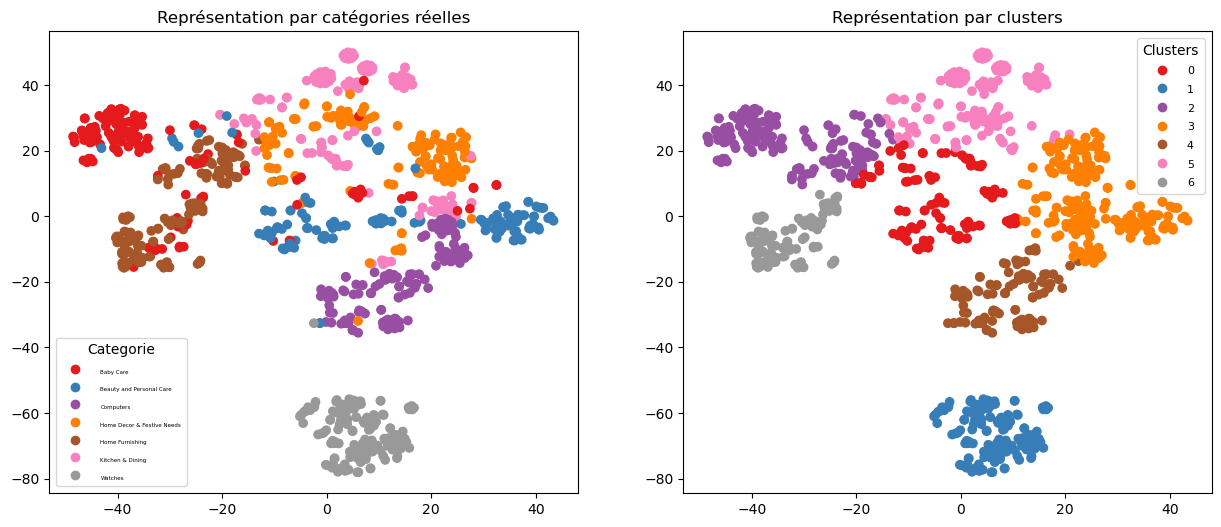

ARI :  0.4345


In [500]:
TSNE_visu_fct(X_tsne, l_cat, data["label"], labels, ARI)

On retrouve les clusters. Quelques produits sont mal étiquetés. Les produits 'Beauty and personal care' et 'Home decor festive needs' se retrouvent dans plusieurs clusters.Le score ARI de 0.4345 nous confirme l'impression.

# Conclusion:

Après cette étude de texte, nous pouvons conclure qu'il est possible de faire une classification automatique des produits. La meilleure approche est tf-idf avec un score ARI de 0,4645.